<a href="https://colab.research.google.com/github/SVL98/SVL98/blob/main/WUSTL_Cuckoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import math  # <-- add this

import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Metrics print function
def print_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    support = len(y_true)

    print("\n🧩 Confusion Matrix:")
    print(cm)
    print("\n📊 Metrics Summary:")
    print(f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print(f"{accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")

# --- Cuckoo Search Implementation ---
def levy_flight(Lambda):
    sigma = (math.gamma(1 + Lambda) * math.sin(math.pi * Lambda / 2) /
         (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)

    u = np.random.normal(0, sigma, size=1)
    v = np.random.normal(0, 1, size=1)
    step = u / abs(v) ** (1 / Lambda)
    return step[0]

def simple_bounds(s, lb, ub):
    return np.clip(s, lb, ub)

def cuckoo_search(obj_func, dim, lb, ub, n=25, pa=0.25, alpha=1, iterations=50):
    nests = np.random.uniform(lb, ub, size=(n, dim))
    fitness = np.array([obj_func(nest) for nest in nests])
    best_idx = np.argmin(fitness)
    best = nests[best_idx].copy()
    best_fitness = fitness[best_idx]

    for t in range(iterations):
        for i in range(n):
            new = nests[i] + alpha * levy_flight(1.5) * (nests[i] - best)
            new = simple_bounds(new, lb, ub)
            new_fit = obj_func(new)

            if new_fit < fitness[i]:
                nests[i] = new
                fitness[i] = new_fit

            if new_fit < best_fitness:
                best = new
                best_fitness = new_fit

        # Abandon some nests
        abandon = np.random.rand(n, dim) < pa
        stepsize = np.random.uniform(lb, ub, size=(n, dim)) * (nests[np.random.permutation(n)] - nests[np.random.permutation(n)])
        nests += abandon * stepsize
        nests = simple_bounds(nests, lb, ub)
        fitness = np.array([obj_func(nest) for nest in nests])

        best_idx = np.argmin(fitness)
        if fitness[best_idx] < best_fitness:
            best = nests[best_idx].copy()
            best_fitness = fitness[best_idx]

    return best, best_fitness

# 1. Load dataset
file_path = "/content/wustl-ehms-2020_with_attacks_categories.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

# 2. Drop unwanted columns
df.drop(columns=['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'Attack Category'], inplace=True, errors='ignore')
df.dropna(subset=['Label'], inplace=True)

# 3. Sampling
benign = df[df['Label'] == 0].sample(n=min(14000, df[df['Label'] == 0].shape[0]), random_state=42)
attack = df[df['Label'] == 1].sample(n=min(1400, df[df['Label'] == 1].shape[0]), random_state=42)
df_sampled = pd.concat([benign, attack]).sample(frac=1.0, random_state=42)

# 4. Preprocess
X_raw = df_sampled.drop(columns=["Label"])
y = df_sampled["Label"].reset_index(drop=True)
feature_names = X_raw.columns.tolist()

# 5. Encode non-numeric columns
for column in X_raw.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_raw[column] = le.fit_transform(X_raw[column].astype(str))

# 6. Impute and scale
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
num_features = X_train.shape[1]

# 8. Define fitness function
def fitness_function(mask):
    mask = np.round(mask).astype(int)
    if np.count_nonzero(mask) == 0:
        return 1
    selected = mask == 1
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_train[:, selected], y_train)
    y_pred = clf.predict(X_test[:, selected])
    return 1 - accuracy_score(y_test, y_pred)

# 9. Run Cuckoo Search
lb = 0
ub = 1
print("\n🔁 Running Cuckoo Search for Feature Selection (RF)...")
best_mask, best_score = cuckoo_search(fitness_function, dim=num_features, lb=lb, ub=ub, n=25, pa=0.25, alpha=1, iterations=50)

# 10. Apply selected features
best_mask = np.round(best_mask).astype(int)
selected_features = np.where(best_mask == 1)[0]
selected_feature_names = [feature_names[i] for i in selected_features]

print(f"\n✅ Selected {len(selected_features)} features using Cuckoo Search:")
print(selected_feature_names)

# 11. Train RF on selected features
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train[:, selected_features], y_train)
y_pred = model.predict(X_test[:, selected_features])

# 12. Evaluate
print(f"\n🎯 Accuracy (Cuckoo Search + RF): {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print_metrics(y_test, y_pred)



🔁 Running Cuckoo Search for Feature Selection (RF)...

✅ Selected 17 features using Cuckoo Search:
['Sport', 'Dport', 'SIntPkt', 'SIntPktAct', 'DIntPktAct', 'dMaxPktSz', 'dMinPktSz', 'Trans', 'TotBytes', 'Loss', 'pLoss', 'pDstLoss', 'Packet_num', 'Temp', 'Pulse_Rate', 'SYS', 'Resp_Rate']

🎯 Accuracy (Cuckoo Search + RF): 98.51%

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2800
           1       0.96      0.87      0.91       280

    accuracy                           0.99      3080
   macro avg       0.98      0.93      0.95      3080
weighted avg       0.98      0.99      0.98      3080


🧩 Confusion Matrix:
[[2791    9]
 [  37  243]]

📊 Metrics Summary:
Accuracy   Precision  Recall     F1-Score   Support   
0.9851     0.9756     0.9323     0.9527     3080      


In [ ]:
import os
import time
import tracemalloc
import numpy as np
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# ------------------ 1. Load dataset ------------------
file_path = "/content/wustl-ehms-2020_with_attacks_categories.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

df.drop(columns=['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'Attack Category'], inplace=True, errors='ignore')
df.dropna(subset=['Label'], inplace=True)

# ------------------ 2. Sample dataset ------------------
benign = df[df['Label'] == 0].sample(n=min(14000, df[df['Label'] == 0].shape[0]), random_state=42)
attack = df[df['Label'] == 1].sample(n=min(1400, df[df['Label'] == 1].shape[0]), random_state=42)
df_sampled = pd.concat([benign, attack]).sample(frac=1.0, random_state=42)

# ------------------ 3. Preprocess ------------------
X_raw = df_sampled.drop(columns=["Label"])
y = df_sampled["Label"].reset_index(drop=True)
feature_names = X_raw.columns.tolist()

for column in X_raw.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_raw[column] = le.fit_transform(X_raw[column].astype(str))

imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# ------------------ 4. Train-test split ------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y,random_state=42)
num_features = X_train.shape[1]

# ------------------ 5. Evaluation Helper ------------------
def print_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    support = len(y_true)

    print("\n🧩 Confusion Matrix:")
    print(cm)

    print("\n📊 Metrics Summary:")
    print(f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print(f"{accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")

# ------------------ 6. Fitness Function ------------------
def fitness_function(position):
    selected = [i for i in range(num_features) if position[i] > 0.5]
    if len(selected) == 0:
        return 1
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train[:, selected], y_train)
    y_pred = clf.predict(X_test[:, selected])
    return 1 - accuracy_score(y_test, y_pred)



# ------------------ 7. Cuckoo Search ------------------
def cuckoo_search(obj_func, n=25, pa=0.25, alpha=1, max_iter=20):
    def levy_flight(Lambda):
        sigma = (math.gamma(1 + Lambda) * math.sin(math.pi * Lambda / 2) /
                 (math.gamma((1 + Lambda) / 2) * Lambda * 2**((Lambda - 1) / 2)))**(1 / Lambda)
        u = np.random.randn(num_features) * sigma
        v = np.random.randn(num_features)
        step = u / (np.abs(v)**(1 / Lambda))
        return step

    # Initialize nests and fitness
    nests = np.random.rand(n, num_features)
    fitness = np.array([obj_func(nest) for nest in nests])
    best_nest = nests[np.argmin(fitness)]
    best_fitness = min(fitness)

    print("📊 Iteration-wise progress:")
    for iteration in range(1, max_iter + 1):
        for i in range(n):
            step_size = levy_flight(1.5)
            new_nest = np.clip(nests[i] + alpha * step_size, 0, 1)
            new_fitness = obj_func(new_nest)
            if new_fitness < fitness[i]:
                nests[i], fitness[i] = new_nest, new_fitness
                if new_fitness < best_fitness:
                    best_nest, best_fitness = new_nest, new_fitness

        # Abandon some nests
        abandon = np.random.rand(n, num_features) < pa
        stepsize = np.random.rand(n, num_features)
        random_nests = nests[np.random.permutation(n)]
        nests = np.clip(nests + stepsize * (random_nests - nests) * abandon, 0, 1)
        fitness = np.array([obj_func(nest) for nest in nests])
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_nest, best_fitness = nests[current_best_idx], fitness[current_best_idx]

        # Print current progress
        current_accuracy = 1 - best_fitness
        print(f"🌀 Iteration {iteration}/{max_iter} | Best Fitness: {best_fitness:.4f} | Accuracy: {current_accuracy:.4f}")

    return best_nest, best_fitness



# ------------------ 8. Run Cuckoo Search ------------------
print("🛸 Running Cuckoo Search for Feature Selection...")
best_position, best_score = cuckoo_search(fitness_function, n=25, max_iter=20)
selected_features = [i for i in range(num_features) if best_position[i] > 0.5]
selected_feature_names = [feature_names[i] for i in selected_features]

print(f"\n✅ Cuckoo Search Completed!")
print(f"Selected Feature Indices: {selected_features}")
print(f"Selected Feature Names: {selected_feature_names}")
print(f"Number of Selected Features: {len(selected_features)}")

# ------------------ 9. Final RF Evaluation ------------------
print("\n🧠 Training Final Random Forest Model with Selected Features")

tracemalloc.start()
start_train = time.perf_counter()

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train[:, selected_features], y_train)

end_train = time.perf_counter()
train_time = end_train - start_train
current_mem_train, peak_mem_train = tracemalloc.get_traced_memory()

start_test = time.perf_counter()
y_pred = clf.predict(X_test[:, selected_features])
end_test = time.perf_counter()
test_time = end_test - start_test
current_mem_test, peak_mem_test = tracemalloc.get_traced_memory()
tracemalloc.stop()

train_acc = accuracy_score(y_train, clf.predict(X_train[:, selected_features]))
test_acc = accuracy_score(y_test, y_pred)

print(f"\n⏱️ Training Time: {train_time:.4f} seconds")
print(f"⏱️ Testing Time: {test_time:.4f} seconds")
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"🎯 Testing Accuracy: {test_acc * 100:.2f}%")
print(f"📊 Number of Selected Features: {len(selected_features)}")
print(f"🧠 Memory Usage (Training): Current = {current_mem_train / 1024:.2f} KB, Peak = {peak_mem_train / 1024:.2f} KB")
print(f"🧠 Memory Usage (Testing): Current = {current_mem_test / 1024:.2f} KB, Peak = {peak_mem_test / 1024:.2f} KB")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print_metrics(y_test, y_pred)


🛸 Running Cuckoo Search for Feature Selection...
📊 Iteration-wise progress:
🌀 Iteration 1/20 | Best Fitness: 0.0299 | Accuracy: 0.9701
🌀 Iteration 2/20 | Best Fitness: 0.0289 | Accuracy: 0.9711
🌀 Iteration 3/20 | Best Fitness: 0.0289 | Accuracy: 0.9711
🌀 Iteration 4/20 | Best Fitness: 0.0276 | Accuracy: 0.9724
🌀 Iteration 5/20 | Best Fitness: 0.0188 | Accuracy: 0.9812
🌀 Iteration 6/20 | Best Fitness: 0.0179 | Accuracy: 0.9821
🌀 Iteration 7/20 | Best Fitness: 0.0179 | Accuracy: 0.9821
🌀 Iteration 8/20 | Best Fitness: 0.0179 | Accuracy: 0.9821
🌀 Iteration 9/20 | Best Fitness: 0.0179 | Accuracy: 0.9821
🌀 Iteration 10/20 | Best Fitness: 0.0140 | Accuracy: 0.9860
🌀 Iteration 11/20 | Best Fitness: 0.0104 | Accuracy: 0.9896
🌀 Iteration 12/20 | Best Fitness: 0.0104 | Accuracy: 0.9896
🌀 Iteration 13/20 | Best Fitness: 0.0104 | Accuracy: 0.9896
🌀 Iteration 14/20 | Best Fitness: 0.0094 | Accuracy: 0.9906
🌀 Iteration 15/20 | Best Fitness: 0.0094 | Accuracy: 0.9906
🌀 Iteration 16/20 | Best Fitness:

In [ ]:
import os
import time
import tracemalloc
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load and preprocess the dataset
file_path = "/content/wustl-ehms-2020_with_attacks_categories.csv"
df = pd.read_csv(file_path)
df.drop(columns=['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'Attack Category'], inplace=True, errors='ignore')
df.dropna(subset=['Label'], inplace=True)

benign = df[df['Label'] == 0].sample(n=min(14000, len(df[df['Label'] == 0])), random_state=42)
attack = df[df['Label'] == 1].sample(n=min(1400, len(df[df['Label'] == 1])), random_state=42)
df_sampled = pd.concat([benign, attack]).sample(frac=1.0, random_state=42)

X_raw = df_sampled.drop(columns=["Label"])
y = df_sampled["Label"].reset_index(drop=True)
feature_names = X_raw.columns.tolist()

for column in X_raw.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_raw[column] = le.fit_transform(X_raw[column].astype(str))

imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
num_features = X_train.shape[1]

# Evaluation helper
def print_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    support = len(y_true)
    print("\n🧩 Confusion Matrix:")
    print(cm)
    print("\n📊 Metrics Summary:")
    print(f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print(f"{accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")

# Fitness function
def fitness_function(position):
    selected = [i for i in range(num_features) if position[i] == 1]
    if len(selected) < 1:
        return 1.0
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train[:, selected], y_train)
    y_pred = clf.predict(X_test[:, selected])
    return 1 - accuracy_score(y_test, y_pred)

# ACO algorithm
def ant_colony_optimization(num_ants=20, num_iter=20, alpha=1.0, beta=1.0, evaporation_rate=0.2, q=1.0):
    pheromone = np.ones(num_features)
    heuristic = np.ones(num_features)
    best_position = None
    best_fitness = float('inf')

    print("📊 Iteration-wise progress:")
    for iteration in range(1, num_iter + 1):
        all_solutions = []
        all_fitness = []

        for ant in range(num_ants):
            prob = (pheromone ** alpha) * (heuristic ** beta)
            prob = prob / prob.sum()
            selected = np.random.rand(num_features) < prob
            while selected.sum() < 10:
                selected[np.random.randint(0, num_features)] = 1
            fitness = fitness_function(selected.astype(int))
            all_solutions.append(selected)
            all_fitness.append(fitness)

        best_idx = np.argmin(all_fitness)
        if all_fitness[best_idx] < best_fitness:
            best_fitness = all_fitness[best_idx]
            best_position = all_solutions[best_idx]

        # Pheromone update
        pheromone *= (1 - evaporation_rate)
        for i in range(num_ants):
            pheromone += q / all_fitness[i] * all_solutions[i]

        print(f"🐜 Iteration {iteration}/{num_iter} | Best Fitness: {best_fitness:.4f} | Accuracy: {1 - best_fitness:.4f}")

    return best_position.astype(int), best_fitness

# Run ACO
print("🐜 Running Ant Colony Optimization for Feature Selection...")
best_position, best_score = ant_colony_optimization()
selected_features = [i for i in range(num_features) if best_position[i] == 1]
selected_feature_names = [feature_names[i] for i in selected_features]

print(f"\n✅ ACO Completed!")
print(f"Selected Feature Indices: {selected_features}")
print(f"Selected Feature Names: {selected_feature_names}")
print(f"Number of Selected Features: {len(selected_features)}")

# Final evaluation
print("\n🧠 Training Final Random Forest Model with Selected Features")

tracemalloc.start()
start_train = time.perf_counter()
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train[:, selected_features], y_train)
end_train = time.perf_counter()
train_time = end_train - start_train
current_mem_train, peak_mem_train = tracemalloc.get_traced_memory()

start_test = time.perf_counter()
y_pred = clf.predict(X_test[:, selected_features])
end_test = time.perf_counter()
test_time = end_test - start_test
current_mem_test, peak_mem_test = tracemalloc.get_traced_memory()
tracemalloc.stop()

train_acc = accuracy_score(y_train, clf.predict(X_train[:, selected_features]))
test_acc = accuracy_score(y_test, y_pred)

print(f"\n⏱️ Training Time: {train_time:.4f} seconds")
print(f"⏱️ Testing Time: {test_time:.4f} seconds")
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"🎯 Testing Accuracy: {test_acc * 100:.2f}%")
print(f"📊 Number of Selected Features: {len(selected_features)}")
print(f"🧠 Memory Usage (Training): Current = {current_mem_train / 1024:.2f} KB, Peak = {peak_mem_train / 1024:.2f} KB")
print(f"🧠 Memory Usage (Testing): Current = {current_mem_test / 1024:.2f} KB, Peak = {peak_mem_test / 1024:.2f} KB")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print_metrics(y_test, y_pred)


🐜 Running Ant Colony Optimization for Feature Selection...
📊 Iteration-wise progress:
🐜 Iteration 1/20 | Best Fitness: 0.0133 | Accuracy: 0.9867
🐜 Iteration 2/20 | Best Fitness: 0.0127 | Accuracy: 0.9873
🐜 Iteration 3/20 | Best Fitness: 0.0127 | Accuracy: 0.9873
🐜 Iteration 4/20 | Best Fitness: 0.0127 | Accuracy: 0.9873
🐜 Iteration 5/20 | Best Fitness: 0.0127 | Accuracy: 0.9873
🐜 Iteration 6/20 | Best Fitness: 0.0127 | Accuracy: 0.9873
🐜 Iteration 7/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 8/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 9/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 10/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 11/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 12/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 13/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 14/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 15/20 | Best Fitness: 0.0097 | Accuracy: 0.9903
🐜 Iteration 16/20 | Bes

PSO+RF

In [ ]:
import os
import time
import tracemalloc
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from functools import partial

# ------------------ 1. Load dataset ------------------
file_path = "/content/wustl-ehms-2020_with_attacks_categories.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

df.drop(columns=['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'Attack Category'], inplace=True, errors='ignore')
df.dropna(subset=['Label'], inplace=True)

# ------------------ 3. Sample dataset ------------------
benign = df[df['Label'] == 0].sample(n=min(14000, df[df['Label'] == 0].shape[0]), random_state=42)
attack = df[df['Label'] == 1].sample(n=min(1400, df[df['Label'] == 1].shape[0]), random_state=42)
df_sampled = pd.concat([benign, attack]).sample(frac=1.0, random_state=42)

# ------------------ 4. Preprocess ------------------
X_raw = df_sampled.drop(columns=["Label"])
y = df_sampled["Label"].reset_index(drop=True)
feature_names = X_raw.columns.tolist()

# Label encode non-numeric features
for column in X_raw.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_raw[column] = le.fit_transform(X_raw[column].astype(str))

# Impute and scale
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# ------------------ 5. Train-test split ------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,stratify=y, random_state=42)
num_features = X_train.shape[1]

#----------------------------------------
def print_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    support = len(y_true)

    print("\n🧩 Confusion Matrix:")
    print(cm)

    print("\n📊 Metrics Summary:")
    print(f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print(f"{accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")

# ------------------ 6. PSO Objective Function ------------------
def fitness_function(position):
    selected = [i for i in range(num_features) if position[i] > 0.5]
    if len(selected) == 0:
        return 1
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train[:, selected], y_train)
    y_pred = clf.predict(X_test[:, selected])
    return 1 - accuracy_score(y_test, y_pred)

# ------------------ 7. PSO Core Algorithm ------------------
def _obj_wrapper(func, args, kwargs, x): return func(x, *args, **kwargs)
def _is_feasible_wrapper(func, x): return np.all(func(x) >= 0)
def _cons_none_wrapper(x): return np.array([0])
def _cons_ieqcons_wrapper(ieqcons, args, kwargs, x): return np.array([y(x, *args, **kwargs) for y in ieqcons])
def _cons_f_ieqcons_wrapper(f_ieqcons, args, kwargs, x): return np.array(f_ieqcons(x, *args, **kwargs))

def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={},
        swarmsize=30, omega=0.5, phip=0.5, phig=0.5, maxiter=20,
        minstep=1e-8, minfunc=1e-8, debug=False, processes=1, particle_output=False):

    assert len(lb) == len(ub)
    lb, ub = np.array(lb), np.array(ub)
    vhigh, vlow = np.abs(ub - lb), -np.abs(ub - lb)

    obj = partial(_obj_wrapper, func, args, kwargs)
    cons = _cons_none_wrapper if f_ieqcons is None and not ieqcons else (
        partial(_cons_f_ieqcons_wrapper, f_ieqcons, args, kwargs) if f_ieqcons else partial(_cons_ieqcons_wrapper, ieqcons, args, kwargs))
    is_feasible = partial(_is_feasible_wrapper, cons)

    S, D = swarmsize, len(lb)
    x = lb + np.random.rand(S, D) * (ub - lb)
    v = np.zeros_like(x)
    p = np.zeros_like(x)
    fx = np.array([obj(xi) for xi in x])
    fs = np.array([is_feasible(xi) for xi in x])
    fp = np.ones(S) * np.inf
    g, fg = None, np.inf

    i_update = np.logical_and(fx < fp, fs)
    p[i_update] = x[i_update]
    fp[i_update] = fx[i_update]

    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        g, fg = p[i_min].copy(), fp[i_min]

    v = vlow + np.random.rand(S, D) * (vhigh - vlow)
    it = 1
    while it <= maxiter:
        rp, rg = np.random.rand(S, D), np.random.rand(S, D)
        v = omega * v + phip * rp * (p - x) + phig * rg * (g - x)
        x = np.clip(x + v, lb, ub)

        fx = np.array([obj(xi) for xi in x])
        fs = np.array([is_feasible(xi) for xi in x])
        i_update = np.logical_and(fx < fp, fs)
        p[i_update] = x[i_update]
        fp[i_update] = fx[i_update]

        i_min = np.argmin(fp)
        if fp[i_min] < fg:
            new_g = p[i_min].copy()
            step = np.linalg.norm(g - new_g)

            # Calculate accuracy for this iteration
            selected = [i for i in range(D) if new_g[i] > 0.5]
            if len(selected) > 0:
                clf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
                clf_temp.fit(X_train[:, selected], y_train)
                y_pred_temp = clf_temp.predict(X_test[:, selected])
                acc = accuracy_score(y_test, y_pred_temp)
                print(f"📈 Iteration {it}: Accuracy = {acc:.4f}, Features = {len(selected)}")

            if np.abs(fg - fp[i_min]) <= minfunc or step <= minstep:
                return (new_g, fp[i_min]) if not particle_output else (new_g, fp[i_min], p, fp)

            g, fg = new_g, fp[i_min]

        it += 1

    return (g, fg) if not particle_output else (g, fg, p, fp)


# ------------------ 8. Run PSO ------------------
print("🚀 Running PSO for Feature Selection...")
lb, ub = [0] * num_features, [1] * num_features
best_position, best_score = pso(fitness_function, lb, ub, swarmsize=30, maxiter=20)

selected_features = [i for i in range(num_features) if best_position[i] > 0.5]
selected_feature_names = [feature_names[i] for i in selected_features]

print(f"\n✅ PSO Completed!")
print(f"Selected Feature Indices: {selected_features}")
print(f"Selected Feature Names: {selected_feature_names}")
print(f"Number of Selected Features: {len(selected_features)}")


# ------------------ 9. Final RF Evaluation ------------------
print("\n🧠 Training Final Random Forest Model with Selected Features")

tracemalloc.start()
start_train = time.perf_counter()

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train[:, selected_features], y_train)

end_train = time.perf_counter()
train_time = end_train - start_train
current_mem_train, peak_mem_train = tracemalloc.get_traced_memory()

start_test = time.perf_counter()
y_pred = clf.predict(X_test[:, selected_features])
end_test = time.perf_counter()
test_time = end_test - start_test
current_mem_test, peak_mem_test = tracemalloc.get_traced_memory()
tracemalloc.stop()

train_acc = accuracy_score(y_train, clf.predict(X_train[:, selected_features]))
test_acc = accuracy_score(y_test, y_pred)

print(f"\n⏱️ Training Time: {train_time:.4f} seconds")
print(f"⏱️ Testing Time: {test_time:.4f} seconds")
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"🎯 Testing Accuracy: {test_acc * 100:.2f}%")
print(f"📊 Number of Selected Features: {len(selected_features)}")
print(f"🧠 Memory Usage (Training): Current = {current_mem_train / 1024:.2f} KB, Peak = {peak_mem_train / 1024:.2f} KB")
print(f"🧠 Memory Usage (Testing): Current = {current_mem_test / 1024:.2f} KB, Peak = {peak_mem_test / 1024:.2f} KB")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print_metrics(y_test, y_pred)

# ------------------ 10. Save Trained Model ------------------
import joblib

model_path = "PSO_rf_model.pkl"
joblib.dump(clf, model_path)
print(f"✅ Model saved to: {model_path}")

#-----------------selectedfeature---
import json

# Save selected feature indices
feature_path = "PSO_selected_features.json"
with open(feature_path, "w") as f:
    json.dump(selected_features, f)
print(f"📊 Selected feature indices saved to: {feature_path}")



🚀 Running PSO for Feature Selection...
📈 Iteration 1: Accuracy = 0.9815, Features = 17
📈 Iteration 2: Accuracy = 0.9831, Features = 11
📈 Iteration 3: Accuracy = 0.9860, Features = 18
📈 Iteration 4: Accuracy = 0.9883, Features = 17
📈 Iteration 6: Accuracy = 0.9906, Features = 14
📈 Iteration 7: Accuracy = 0.9909, Features = 13
📈 Iteration 9: Accuracy = 0.9922, Features = 14

✅ PSO Completed!
Selected Feature Indices: [0, 2, 3, 7, 10, 14, 15, 17, 23, 25, 28, 32, 33, 35]
Selected Feature Names: ['Sport', 'SrcBytes', 'DstBytes', 'DstGap', 'SIntPktAct', 'sMaxPktSz', 'dMaxPktSz', 'dMinPktSz', 'Loss', 'pSrcLoss', 'Packet_num', 'SYS', 'DIA', 'Resp_Rate']
Number of Selected Features: 14

🧠 Training Final Random Forest Model with Selected Features

⏱️ Training Time: 4.2838 seconds
⏱️ Testing Time: 0.0752 seconds
✅ Training Accuracy: 100.00%
🎯 Testing Accuracy: 99.22%
📊 Number of Selected Features: 14
🧠 Memory Usage (Training): Current = 158.73 KB, Peak = 3217.57 KB
🧠 Memory Usage (Testing): Curre

In [ ]:
import joblib

# Save the trained Random Forest model
model_path = "/content/PSO_rf_model.pkl"
joblib.dump(clf, model_path)
print(f"🧠 Model saved to: {model_path}")

import json

# Save selected feature indices
feature_path = "/content/PSO_selected_features.json"
with open(feature_path, "w") as f:
    json.dump(selected_features, f)
print(f"📊 Selected feature indices saved to: {feature_path}")

🧠 Model saved to: /content/PSO_rf_model.pkl
📊 Selected feature indices saved to: /content/PSO_selected_features.json


In [ ]:
import pandas as pd
import joblib
import json
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# --------- Function to Print Metrics ----------
def print_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    support = len(y_true)

    print("\n🧩 Confusion Matrix:")
    print(cm)

    print("\n📊 Metrics Summary:")
    print(f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print(f"{accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")

# --------- Load Trained Model ----------
model_path = "/content/PSO_rf_model.pkl"  # Change path if needed
rf_model = joblib.load(model_path)
print(f"✅ Loaded model from: {model_path}")

# --------- Load Selected Feature Indices ----------
feature_path = "/content/PSO_selected_features.json"  # Change if needed
with open(feature_path, "r") as f:
    selected_features = json.load(f)
print(f"📊 Loaded selected feature indices: {selected_features}")

# --------- Load New Dataset ----------
new_data_path = "/content/wustl-ehms-2020_with_attacks_categories.csv"  # Change path to your new dataset
new_df = pd.read_csv(new_data_path)

# --------- Drop Unused Columns (same as training) ----------
new_df.drop(columns=['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'Attack Category'], inplace=True, errors='ignore')

# --------- Check if Labels exist ----------
has_labels = 'Label' in new_df.columns
if has_labels:
    y_true = new_df['Label'].values
    new_df.drop(columns=['Label'], inplace=True)

# --------- Encode categorical features ----------
for col in new_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    new_df[col] = le.fit_transform(new_df[col].astype(str))

# --------- Select only the features used in training ----------
# Assuming selected_features is a list of integer column indices
new_df_selected = new_df.iloc[:, selected_features]

# --------- Impute missing values ----------
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(new_df_selected)

# --------- Scale features ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# --------- Predict using loaded model ----------
y_pred = rf_model.predict(X_scaled)

# --------- Print predictions ----------
print(f"✅ Predictions:\n{y_pred}")

# --------- Print metrics if labels available ----------
if has_labels:
    print("\n📄 Classification Report on New Data:")
    print(classification_report(y_true, y_pred))
    print_metrics(y_true, y_pred)
else:
    print("ℹ️ No true labels found in the new dataset. Skipping metrics evaluation.")


✅ Loaded model from: /content/PSO_rf_model.pkl
📊 Loaded selected feature indices: [0, 2, 3, 7, 10, 14, 15, 17, 23, 25, 28, 32, 33, 35]
✅ Predictions:
[0 0 0 ... 0 0 0]

📄 Classification Report on New Data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14272
           1       0.94      0.87      0.90      2046

    accuracy                           0.98     16318
   macro avg       0.96      0.93      0.94     16318
weighted avg       0.98      0.98      0.98     16318


🧩 Confusion Matrix:
[[14164   108]
 [  274  1772]]

📊 Metrics Summary:
Accuracy   Precision  Recall     F1-Score   Support   
0.9766     0.9618     0.9293     0.9447     16318     


In [ ]:
# ------------------ 1. Import Libraries ------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from math import gamma
import time
import psutil
import os

# ------------------ 1. Load dataset ------------------
file_path = "/content/wustl-ehms-2020_with_attacks_categories.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

df.drop(columns=['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'Attack Category'], inplace=True, errors='ignore')
df.dropna(subset=['Label'], inplace=True)

# ------------------ 2. Sample dataset ------------------
benign = df[df['Label'] == 0].sample(n=min(14000, df[df['Label'] == 0].shape[0]), random_state=42)
attack = df[df['Label'] == 1].sample(n=min(1400, df[df['Label'] == 1].shape[0]), random_state=42)
df_sampled = pd.concat([benign, attack]).sample(frac=1.0, random_state=42)

# ------------------ 3. Encode Labels ------------------
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# ------------------ 4. Split Features and Target ------------------
X = data.drop(columns=['Label'])
y = data['Label']
feature_names = X.columns.tolist()
num_features = X.shape[1]

# ------------------ 5. Train-Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ------------------ 6. Define Fitness Function ------------------
def fitness_function(*args):
    # Convert args to binary feature selection vector
    feature_mask = [1 if x > 0.5 else 0 for x in args]
    if sum(feature_mask) == 0:
        return 1e5  # Avoid empty feature set
    selected_indices = [i for i, bit in enumerate(feature_mask) if bit == 1]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train.iloc[:, selected_indices], y_train)
    y_pred = clf.predict(X_test.iloc[:, selected_indices])
    acc = accuracy_score(y_test, y_pred)
    return 1 - acc  # Minimize error

# ------------------ 7. Define Custom Cuckoo Search Class ------------------
class CuckooSearch():
    def __init__(self, fitness, population=25, dimentions=44, beta=1.5, pa=0.25, iterations=20, verbose=True, plot_graph=False):
        self.fitness = fitness
        self.population = population
        self.dimentions = dimentions
        self.beta = beta
        self.pa = pa
        self.iterations = iterations
        self.verbose = verbose
        self.plot_graph = plot_graph

    def generate_nests(self):
        nests = np.random.rand(self.population, self.dimentions)
        return nests

    def levy_flight(self):
        num = gamma(1 + self.beta) * np.sin(np.pi * (self.beta / 2))
        den = gamma((1 + self.beta) / 2) * self.beta * (2**((self.beta - 1) / 2))
        sgu = (num / den)**(1 / self.beta)
        sgv = 1
        u = np.random.normal(0, sgu, self.dimentions)
        v = np.random.normal(0, sgv, self.dimentions)
        S = u / (np.abs(v)**(1 / self.beta))
        return S

    def do_iter(self, nests, random_step):
        best_nest = self.get_best_nest(*nests)
        for i in range(self.population):
            value_change = np.random.randn(self.dimentions) * 0.01 * random_step * (nests[i,:] - best_nest)
            nests[i,:] = self.get_best_nest(nests[i,:], nests[i,:] + value_change)
        nests = self.abandon_nests(nests)
        return nests

    def abandon_nests(self, nests):
        nests_new = nests.copy()
        nests_result = nests.copy()
        for i in range(self.population):
            d1, d2 = np.random.randint(0, self.population, 2)
            for j in range(self.dimentions):
                r = np.random.rand()
                if r < self.pa:
                    nests_new[i,j] += np.random.rand() * (nests[d1, j] - nests[d2, j])
            nests_result[i,:] = self.get_best_nest(nests_new[i,:], nests[i,:])
        return nests_result

    def get_fitness(self, nest):
        return self.fitness(*nest)

    def get_best_nest(self, *nests):
        best_nest = min(nests, key=lambda x: np.abs(self.get_fitness(x)))
        return best_nest

    def run(self):
        nests = self.generate_nests()
        solutions = []

        if self.plot_graph:
            fitness_values = []

        for i in range(self.iterations):
            random_step = self.levy_flight()
            nests = self.do_iter(nests, random_step)
            best_nest = self.get_best_nest(*nests)
            nest_fitness = self.get_fitness(best_nest)
            solutions.append((i, best_nest))
            if self.verbose:
                print(f"Iteration: {i+1}, Best Fitness: {nest_fitness}")
            if self.plot_graph:
                fitness_values.append(nest_fitness)

        if self.plot_graph:
            plt.plot(range(self.iterations), fitness_values)
            plt.xlabel('Iteration')
            plt.ylabel('Fitness')
            plt.title('Fitness Progression')
            plt.show()

        return solutions

# ------------------ 8. Run Cuckoo Search ------------------
print("🛸 Running Cuckoo Search for Feature Selection...")
start_time = time.time()
process = psutil.Process(os.getpid())
start_memory = process.memory_info().rss / 1024 / 1024  # in MB

cs = CuckooSearch(fitness_function, population=25, dimentions=num_features, iterations=20, verbose=True, plot_graph=True)
solution = cs.run()

end_time = time.time()
end_memory = process.memory_info().rss / 1024 / 1024  # in MB

best_nest = min(solution, key=lambda x: fitness_function(*x[1]))[1]
selected_features = [i for i in range(num_features) if best_nest[i] > 0.5]
selected_feature_names = [feature_names[i] for i in selected_features]

print("\n✅ Selected Features:", selected_feature_names)
print("💡 Number of Features Selected:", len(selected_features))

# ------------------ 9. Train Final Model ------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train.iloc[:, selected_features], y_train)
y_pred = clf.predict(X_test.iloc[:, selected_features])

# ------------------ 10. Evaluation ------------------
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"⏱️ Time Taken: {end_time - start_time:.2f} seconds")
print(f"💾 Memory Used: {end_memory - start_memory:.2f} MB")


🛸 Running Cuckoo Search for Feature Selection...
📈 Iteration 1: Accuracy = 0.9977, Features = 20
📈 Iteration 2: Accuracy = 0.9977, Features = 20
📈 Iteration 3: Accuracy = 0.9977, Features = 20
📈 Iteration 4: Accuracy = 0.9977, Features = 20
📈 Iteration 5: Accuracy = 0.9977, Features = 20
📈 Iteration 6: Accuracy = 0.9977, Features = 20
📈 Iteration 7: Accuracy = 0.9977, Features = 20
📈 Iteration 8: Accuracy = 0.9977, Features = 20
📈 Iteration 9: Accuracy = 0.9977, Features = 20
📈 Iteration 10: Accuracy = 0.9977, Features = 20


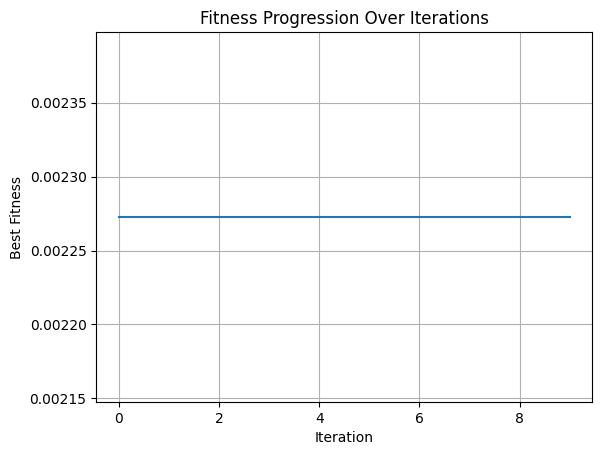


✅ Selected Features (20): ['Sport', 'SrcGap', 'DstGap', 'SIntPkt', 'DIntPkt', 'SIntPktAct', 'SrcJitter', 'dMaxPktSz', 'dMinPktSz', 'Load', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss', 'Rate', 'SpO2', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST']

🧠 Training Final Random Forest Model with Selected Features

⏱️ Training Time: 4.5000 seconds
⏱️ Testing Time: 0.1157 seconds
✅ Training Accuracy: 100.00%
🎯 Testing Accuracy: 95.29%
📊 Number of Selected Features: 20
🧠 Memory Usage (Training): Current = 146.60 KB, Peak = 4077.93 KB
🧠 Memory Usage (Testing): Current = 177.65 KB, Peak = 4077.93 KB

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2800
           1       0.99      0.49      0.65       280

    accuracy                           0.95      3080
   macro avg       0.97      0.74      0.81      3080
weighted avg       0.95      0.95      0.95      3080

Accuracy:  0.9529
Precision: 0.9856
Recall:    0.4893
F1-Score

In [ ]:
# Final integrated code with Cuckoo Search + Random Forest including dataset loading, sampling, training, testing, and metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ------------------ 1. Load dataset ------------------
file_path = "/content/wustl-ehms-2020_with_attacks_categories.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

df.drop(columns=['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'Attack Category'], inplace=True, errors='ignore')
df.dropna(subset=['Label'], inplace=True)

# ------------------ 2. Sample dataset ------------------
benign = df[df['Label'] == 0].sample(n=min(14000, df[df['Label'] == 0].shape[0]), random_state=42)
attack = df[df['Label'] == 1].sample(n=min(1400, df[df['Label'] == 1].shape[0]), random_state=42)
df_sampled = pd.concat([benign, attack]).sample(frac=1.0, random_state=42)

# ------------------ 3. Preprocessing ------------------
label_encoders = {}
for column in df_sampled.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_sampled[column] = le.fit_transform(df_sampled[column])
    label_encoders[column] = le

X = df_sampled.drop(columns=['Label']).values
y = df_sampled['Label'].values
feature_names = df_sampled.drop(columns=['Label']).columns.tolist()
num_features = X.shape[1]

# ------------------ 4. Train-test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

# ------------------ 5. Evaluation Metric ------------------
def print_metrics(y_true, y_pred):
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")

# ------------------ 6. Fitness Function ------------------
def fitness_function(*nest):
    binary_mask = [1 if val > 0.5 else 0 for val in nest]
    if sum(binary_mask) == 0:
        return 1.0  # worst fitness
    X_selected = X_train[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_selected, y_train)
    acc = accuracy_score(y_train, clf.predict(X_selected))
    return 1 - acc

# ------------------ 7. Cuckoo Search Class ------------------
from math import gamma

class CuckooSearch:
    def __init__(self, fitness, population=25, dimensions=44, beta=1.5, pa=0.25, iterations=10, verbose=True, plot_graph=True):
        self.fitness = fitness
        self.population = population
        self.dimensions = dimensions
        self.beta = beta
        self.pa = pa
        self.iterations = iterations
        self.verbose = verbose
        self.plot_graph = plot_graph

    def generate_nests(self):
        return np.random.rand(self.population, self.dimensions)

    def levy_flight(self):
        num = gamma(1 + self.beta) * np.sin(np.pi * (self.beta / 2))
        den = gamma((1 + self.beta) / 2) * self.beta * (2**((self.beta - 1) / 2))
        sgu = (num / den)**(1 / self.beta)
        u = np.random.normal(0, sgu, self.dimensions)
        v = np.random.normal(0, 1, self.dimensions)
        return u / (np.abs(v) ** (1 / self.beta))

    def get_fitness(self, nest):
        return self.fitness(*nest)

    def get_best_nest(self, *nests):
        return min(nests, key=lambda x: self.get_fitness(x))

    def abandon_nests(self, nests):
        new_nests = nests.copy()
        for i in range(self.population):
            d1, d2 = np.random.randint(0, self.population, 2)
            for j in range(self.dimensions):
                if np.random.rand() < self.pa:
                    new_nests[i, j] += np.random.rand() * (nests[d1, j] - nests[d2, j])
        return np.array([self.get_best_nest(nests[i], new_nests[i]) for i in range(self.population)])

    def do_iter(self, nests, step):
        best = self.get_best_nest(*nests)
        for i in range(self.population):
            move = np.random.randn(self.dimensions) * 0.01 * step * (nests[i] - best)
            nests[i] = self.get_best_nest(nests[i], nests[i] + move)
        return self.abandon_nests(nests)

    def run(self):
        nests = self.generate_nests()
        best_fitness_progression = []
        for i in range(self.iterations):
            step = self.levy_flight()
            nests = self.do_iter(nests, step)
            best = self.get_best_nest(*nests)
            fit = self.get_fitness(best)
            best_fitness_progression.append(fit)
            if self.verbose:
                acc = 1 - fit
                selected = [i for i in range(self.dimensions) if best[i] > 0.5]
                if len(selected) == 0:
                    continue
                print(f"📈 Iteration {i+1}: Accuracy = {acc:.4f}, Features = {len(selected)}")
        if self.plot_graph:
            plt.plot(best_fitness_progression)
            plt.xlabel("Iteration")
            plt.ylabel("Best Fitness")
            plt.title("Fitness Progression Over Iterations")
            plt.grid(True)
            plt.show()
        return best, min(best_fitness_progression)

# ------------------ 8. Run Cuckoo Search ------------------
print("🛸 Running Cuckoo Search for Feature Selection...")
cs = CuckooSearch(fitness_function, population=25, dimensions=num_features, iterations=10)
best_position, best_score = cs.run()
selected_features = [i for i in range(num_features) if best_position[i] > 0.5]
selected_feature_names = [feature_names[i] for i in selected_features]
print(f"\n✅ Selected Features ({len(selected_features)}): {selected_feature_names}")

# ------------------ 9. Final RF Evaluation ------------------
print("\n🧠 Training Final Random Forest Model with Selected Features")

tracemalloc.start()
start_train = time.perf_counter()

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train[:, selected_features], y_train)

end_train = time.perf_counter()
train_time = end_train - start_train
current_mem_train, peak_mem_train = tracemalloc.get_traced_memory()

start_test = time.perf_counter()
y_pred = clf.predict(X_test[:, selected_features])
end_test = time.perf_counter()
test_time = end_test - start_test
current_mem_test, peak_mem_test = tracemalloc.get_traced_memory()
tracemalloc.stop()

train_acc = accuracy_score(y_train, clf.predict(X_train[:, selected_features]))
test_acc = accuracy_score(y_test, y_pred)

print(f"\n⏱️ Training Time: {train_time:.4f} seconds")
print(f"⏱️ Testing Time: {test_time:.4f} seconds")
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"🎯 Testing Accuracy: {test_acc * 100:.2f}%")
print(f"📊 Number of Selected Features: {len(selected_features)}")
print(f"🧠 Memory Usage (Training): Current = {current_mem_train / 1024:.2f} KB, Peak = {peak_mem_train / 1024:.2f} KB")
print(f"🧠 Memory Usage (Testing): Current = {current_mem_test / 1024:.2f} KB, Peak = {peak_mem_test / 1024:.2f} KB")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
print_metrics(y_test, y_pred)

# ------------------ 10. Save Trained Model ------------------
import joblib

model_path = "CUCkoo_rf_model.pkl"
joblib.dump(clf, model_path)
print(f"✅ Model saved to: {model_path}")

#-----------------selectedfeature---
import json

# Save selected feature indices
feature_path = "CoCkoo_selected_features.json"
with open(feature_path, "w") as f:
    json.dump(selected_features, f)
print(f"📊 Selected feature indices saved to: {feature_path}")


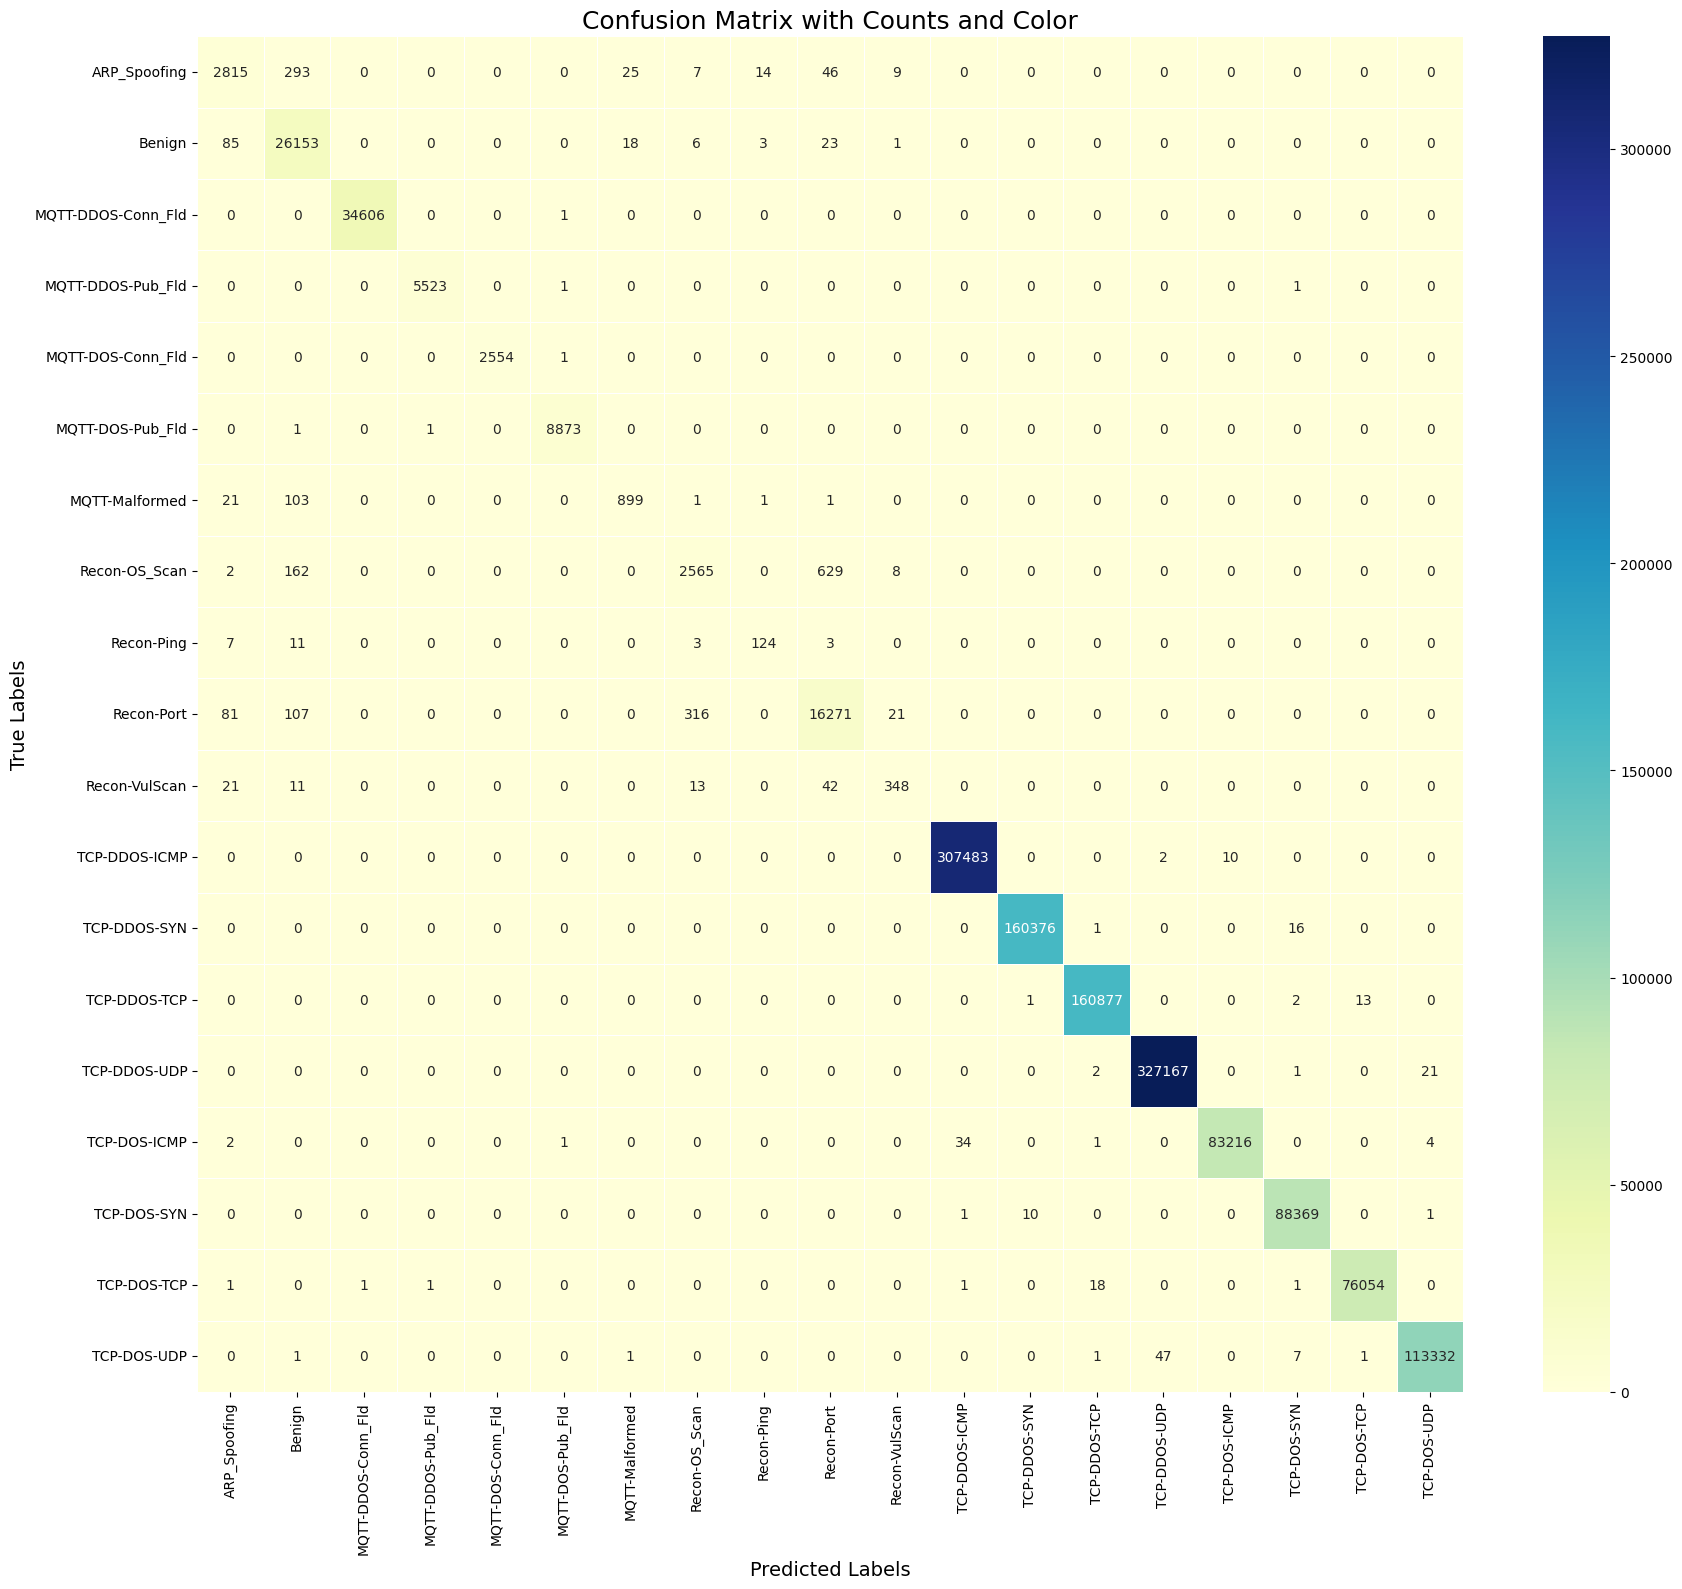

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrix data (same as before)
cm = np.array([
    [2815, 293, 0, 0, 0, 0, 25, 7, 14, 46, 9, 0, 0, 0, 0, 0, 0, 0, 0],
    [85, 26153, 0, 0, 0, 0, 18, 6, 3, 23, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 34606, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 5523, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 2554, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 8873, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [21, 103, 0, 0, 0, 0, 899, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 162, 0, 0, 0, 0, 0, 2565, 0, 629, 8, 0, 0, 0, 0, 0, 0, 0, 0],
    [7, 11, 0, 0, 0, 0, 0, 3, 124, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [81, 107, 0, 0, 0, 0, 0, 316, 0, 16271, 21, 0, 0, 0, 0, 0, 0, 0, 0],
    [21, 11, 0, 0, 0, 0, 0, 13, 0, 42, 348, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 307483, 0, 0, 2, 10, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 160376, 1, 0, 0, 16, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 160877, 0, 0, 2, 13, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 327167, 0, 1, 0, 21],
    [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 34, 0, 1, 0, 83216, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 10, 0, 0, 0, 88369, 0, 1],
    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 18, 0, 0, 1, 76054, 0],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 47, 0, 7, 1, 113332]
])

# Class labels
labels = [
    "ARP_Spoofing", "Benign", "MQTT-DDOS-Conn_Fld", "MQTT-DDOS-Pub_Fld",
    "MQTT-DOS-Conn_Fld", "MQTT-DOS-Pub_Fld", "MQTT-Malformed", "Recon-OS_Scan",
    "Recon-Ping", "Recon-Port", "Recon-VulScan", "TCP-DDOS-ICMP", "TCP-DDOS-SYN",
    "TCP-DDOS-TCP", "TCP-DDOS-UDP", "TCP-DOS-ICMP", "TCP-DOS-SYN", "TCP-DOS-TCP", "TCP-DOS-UDP"
]

# Plot heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels, linewidths=.5, cbar=True)

# Titles and axis labels
plt.title('Confusion Matrix with Counts and Color', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
